<a href="https://colab.research.google.com/github/kumiori/mec647/blob/philipp-epMesh/mec647_Elast_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [3]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

# The problem of elasticity


Let $\Omega \subset (0, L)^D$, with $D=1, 2, 3$, $L$ finite, being the (or one) characteristic length of the specimen. For any $u\in V_t : H^1(\Omega, R^n) + bcs(t)$ with $n=1, 2$ or $3$, consider the energy $E(u)$ defined as
$$
E(u)=\frac{1}{2}\int_\Omega A e(u): e(u) dx - \int_\Omega f.u dx$$
Above, $A$ is the 4-th order tensor of elasticity, in the isotropic and homogeneous case, it corresponds to a linear combination with two coefficients, say, $A_0$ the stiffness (dimensional), and $\nu$ the Poisson ratio (non-dimensional). 

We solve:
$$min \left\{ E(u):  u \in V_t\right\}$$. 

From a mechanical  standpoint, linear elasticity is the limit regime of small deformations of the general, fully nonlinear, problem of elasticity.  
From a mathematical standpoint, the minimisation problem above is a standard variational problem which is i) convex, ii) defined on a complete, compact,  vector space of functions, and iii) . Its solution is unique and depends continuously upon the data. Can you show this?  

Boundary conditions are such that equilibrium ...

The interest of the above is that $E(u)$ ...


In [4]:
# library include


import numpy as np
import yaml
import json
import sys
import os
from pathlib import Path

from mpi4py import MPI

import petsc4py
from petsc4py import PETSc

import dolfinx
import dolfinx.plot
from dolfinx import log
import ufl


from dolfinx.io import XDMFFile

import logging

logging.basicConfig(level=logging.INFO)

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)
import matplotlib.pyplot as plt
import pyvista 
from pyvista.utilities import xvfb 

In [5]:
!rm -rf mec647


In [6]:
try:
  !git clone -b philipp-epMesh https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')

  !rm -rf mec647
  !git clone -b philipp-epMesh https://github.com/kumiori/mec647.git


Cloning into 'mec647'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (470/470), done.
remote: Total 575 (delta 251), reused 255 (delta 86), pack-reused 0
Receiving objects: 100% (575/575), 12.29 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [7]:
sys.path.append('mec647/')

# meshes
import meshes
from meshes import primitives

# visualisation
from utils import viz
import matplotlib.pyplot as plt
from utils.viz import plot_mesh, plot_vector, plot_scalar


In [8]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 5.,
        'Ly': 15
    },
    'model': {
        'mu': 1.,
        'lmbda': 0.
    },
    'solvers': {
        'snes': {
            'snes_type': 'newtontr',
            'snes_stol': 1e-8,
            'snes_atol': 1e-8,
            'snes_rtol': 1e-8,
            'snes_max_it': 100,
            'snes_monitor': "",
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps'
        }
    }
}

# parameters.get('loading')



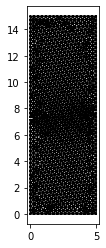

In [9]:
# Mesh
Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]



gmsh_model, tdim = primitives.mesh_ep_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    1, 
                                    0.5,
                                    0.3, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2, 
                               exportMesh=True, 
                               fileName="epTestMesh.msh")

# TODO: Plot mesh


plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")


In [28]:
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], Lx)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], Ly))]

facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full(len(facets), marker))
facet_indices = np.array(np.hstack(facet_indices), dtype=np.int32)
facet_markers = np.array(np.hstack(facet_markers), dtype=np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dolfinx.mesh.MeshTags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


In [29]:
facet_markers

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4], dtype=int32)

In [30]:
# Functional setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)
V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 

u = dolfinx.fem.Function(V_u, name="Displacement")
g = dolfinx.fem.Function(V_u, name="Body pressure")

u_ = dolfinx.fem.Function(V_u, name="Boundary Displacement")
# ux_ = dolfinx.fem.Function(V_u.sub(0).collapse(), name="Boundary Displacement")




In [31]:
# Integral measures
dx = ufl.Measure("dx", domain=mesh)
ds = ufl.Measure("ds", domain=mesh)
dS = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)
x = ufl.SpatialCoordinate(mesh)

In [65]:

# Data

zero = Function(V_u)
# works in parallel!
with zero.vector.localForm() as loc:
    loc.set(0.0)

one = Function(V_u)
# works in parallel!
with one.vector.localForm() as loc:
    loc.set(1.0)

g = Function(V_u)
# works in parallel!
with g.vector.localForm() as loc:
    loc.set(1.0)


In [66]:
# boundary conditions

def left(x):
  return np.isclose(x[0], 0.)

def right(x):
  return np.isclose(x[0], Lx)

def bottom(x):
  return np.isclose(x[1], 0.)

def top(x):
  return np.isclose(x[1], Ly)

# left side

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                left_facets)


# right side

right_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, right)
right_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                right_facets)


top_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, top)
top_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                top_facets)

bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, bottom)
bottom_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                bottom_facets)



In [67]:
# energy
mu = parameters["model"]["mu"]
lmbda = parameters["model"]["lmbda"]

def _e(u):
  return ufl.sym(ufl.grad(u))

en_density = 1/2 * (2*mu* ufl.inner(_e(u),_e(u))) + lmbda*ufl.tr(_e(u))**2
energy = en_density * dx + ufl.inner(u, g)*dS(4)

In [68]:

#bcs = [dirichletbc(zero, bottom_dofs), dirichletbc(one, top_dofs)]
bcs = [dirichletbc(zero, bottom_dofs)]
bcs

In [69]:

# solving
from solvers import SNESSolver
D_energy_u = ufl.derivative(energy, u, ufl.TestFunction(V_u))

problem = SNESSolver(
    D_energy_u,
    u,
    bcs,
    bounds=None,
    petsc_options=parameters.get("solvers").get("snes"),
    prefix="elast",
)


uh = problem.solve()


  0 SNES Function norm 1.689577248982e+00 
  1 SNES Function norm 1.689518153588e+00 
  2 SNES Function norm 1.689399962801e+00 
  3 SNES Function norm 1.689163581227e+00 
  4 SNES Function norm 1.688690818078e+00 
  5 SNES Function norm 1.687745291781e+00 
  6 SNES Function norm 1.685854239186e+00 
  7 SNES Function norm 1.682072133996e+00 
  8 SNES Function norm 1.674507923617e+00 
  9 SNES Function norm 1.659379502859e+00 
 10 SNES Function norm 1.629122661342e+00 
 11 SNES Function norm 1.568608978309e+00 
 12 SNES Function norm 1.447581612242e+00 
 13 SNES Function norm 1.205526880108e+00 
 14 SNES Function norm 7.214174158410e-01 
 15 SNES Function norm 2.922162465599e-12 


## Visualisation & Post Processing

In [80]:

def plot_vector(u, plotter, subplot=None):
    if subplot:
        plotter.subplot(subplot[0], subplot[1])
    V = u.function_space
    mesh = V.mesh
    topology, cell_types, _ = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    num_dofs_local = u.function_space.dofmap.index_map.size_local
    geometry = u.function_space.tabulate_dof_coordinates()[:num_dofs_local]
    values = np.zeros((V.dofmap.index_map.size_local, 3), dtype=np.float64)
    values[:, : mesh.geometry.dim] = u.vector.array.real.reshape(
        V.dofmap.index_map.size_local, V.dofmap.index_map_bs
    )
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    #grid["vectors"] = values
    #grid.set_active_vectors("vectors")
    
    # geom = pyvista.Arrow()
    # glyphs = grid.glyph(orient="vectors", factor=1, geom=geom)
    glyphs = grid.glyph(orient="vectors", factor=1.0)
    plotter.add_mesh(glyphs)
    plotter.add_mesh(
        grid, show_edges=True, color="black", style="wireframe", opacity=0.3
    )
    plotter.view_xy()
    return plotter


def plot_scalar(alpha, plotter, subplot=None, lineproperties={}):
    if subplot:
        plotter.subplot(subplot[0], subplot[1])
    V = alpha.function_space
    mesh = V.mesh
    topology, cell_types, _ = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

    plotter.subplot(0, 0)
    grid.point_data["alpha"] = alpha.compute_point_values().real
    grid.set_active_scalars("alpha")
    plotter.add_mesh(grid, **lineproperties)
    plotter.view_xy()
    return plotter



In [81]:


# plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
# fig.savefig(f"mesh.png")

# postprocessing
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(2, 1),
    )
#_plt = plot_scalar(u_.sub(0), plotter, subplot=(1, 0))
_plt = plot_vector(u, plotter, subplot=(0, 0))

_plt.screenshot(f"displacement_MPI.png")

ValueError: ignored

In [78]:
# plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
# fig.savefig(f"mesh.png")

# postprocessing
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(2, 1),
    )
#_plt = plot_scalar(u_.sub(0), plotter, subplot=(1, 0))
_plt = plot_scalar(u.x.array[::2], plotter, subplot=(0, 0))

_plt.screenshot(f"x_displacement_MPI.png")

AttributeError: ignored

In [44]:
def sigma(u):
    return lmbda * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*_e(u)

In [45]:
s = sigma(u) -1./3*ufl.tr(sigma(u))*ufl.Identity(u.geometric_dimension())
von_Mises = ufl.sqrt(3./2*ufl.inner(s, s))

In [46]:
V_von_mises = FunctionSpace(mesh, ("DG", 0))
stress_expr = dolfinx.fem.Expression(von_Mises, V_von_mises.element.interpolation_points)
stresses = Function(V_von_mises)
stresses.interpolate(stress_expr)

In [50]:
topology, cell_types, _ = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

warped = grid.warp_by_vector("u", factor=1.5)
warped.cell_data["VonMises"] = stresses.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   pyvista.start_xvfb()
   stress_figure = p.screenshot(f"stresses.png")

ValueError: ignored

In [61]:
pyvista.set_jupyter_backend("pythreejs")

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

# Attach vector values to grid and warp grid by vector
grid["u"] = u.x.array.reshape((geometry.shape[0], 2))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   pyvista.start_xvfb()
   figure_as_array = p.screenshot("deflection.png")

ValueError: ignored

In [64]:
u.x.array

array([0., 0., 0., ..., 0., 0., 0.])

AttributeError: ignored